# 2 Denoising of a CT image

In [288]:
import numpy as np
import scipy.sparse as spp
import scipy.sparse.linalg as sppl
import scipy.ndimage.filters as snf
import matplotlib.pyplot as plt


In [289]:
def construct_X(M: int, alphas: np.ndarray, NP=None, tau=0) -> spp.spmatrix:
    """Construct the weight Matrix X for the given M, alphas and optionally NP.

    Parameters
    ----------
    M : int
        Amount of pixels, creates tomogram size `D=M×M`
    alphas : np.ndarray
        Numpy 1D array of all measurement angles.
    NP : int, optional
        Sensor resolution, by default None.
    tau : int
        Used for ridge regression.

    Returns
    -------
    np.ndarray
        Weight matrix X.
    """

    if NP is None:
        NP = int(np.ceil(np.sqrt(2)*M)) + 1

    D = M*M
    N = len(alphas)*NP

    coordinate_origin = -(M//2)
    C = np.zeros((2, D))
    C[0] = coordinate_origin + (np.mgrid[0:M*M] % M)
    C[1] = coordinate_origin + (np.mgrid[0:M*M]//M)

    n = np.zeros((2, len(alphas)))

    alphas_rad = -np.deg2rad(alphas)  # flip image
    n[0, :] = np.cos(alphas_rad)
    n[1, :] = np.sin(alphas_rad)

    s_0 = NP//2
    # project the rays onto the sensor bins
    p = n.T.dot(C) + s_0 + 1e-8

    sensor_lower = np.floor(p).astype(int)  # the lower bin index of the sensor
    sensor_upper = np.ceil(p).astype(int)  # the upper bin index of the sensor
    # the percentage of the lower bin index of the sensor
    weights_lower = sensor_upper - p
    # the percentage of the upper bin index of the sensor
    weights_upper = p - sensor_lower

    weights_lower = weights_lower.reshape(-1)
    weights_upper = weights_upper.reshape(-1)

    i_p, j_indices = np.mgrid[0:len(alphas), 0:D]

    # calculate the i for the lower/upper sensor bins
    i_lower = sensor_lower + NP*i_p
    i_upper = sensor_upper + NP*i_p

    j_indices = j_indices.reshape(-1)

    i_lower = i_lower.reshape(-1)
    i_upper = i_upper.reshape(-1)

    i_indices = np.append(i_lower, i_upper).astype(int)
    j_indices = np.append(j_indices, j_indices)
    weights = np.append(weights_lower, weights_upper)

    weights = weights.reshape(-1)
    i_indices = i_indices.reshape(-1)
    j_indices = j_indices.reshape(-1)

    # Ridge Regression
    if tau > 0:
        ridge_j = np.arange(D)
        ridge_i = np.arange(D) + N
        ridge_weights = np.ones(D) * np.sqrt(tau)

        i_indices = np.append(i_indices, ridge_i)
        j_indices = np.append(j_indices, ridge_j)
        weights = np.append(weights, ridge_weights)
        N = N+D

    X = spp.coo_matrix((weights, (i_indices, j_indices)),
                       shape=(N, D), dtype=np.float32)

    return X


In [290]:
def reduce_to_angles(n, alphas, y, N_p):
    """Reduce the given alphas and y to the given n elements.

    Parameters
    ----------
    n : int
        The amount of elements you want to keep.
    alphas : np.ndarray
        The alphas to reduce to the given element count.
    y : np.ndarray
        The y labels to the corresponding alphas.
    N_p : int
        The sensor count.

    Returns
    -------
    Tuple[np.ndarray, np.ndarray]
        The reduced alphas and y labels of the size n
    """

    N = len(alphas)
    indices = np.linspace(0, N - 1, n).astype(int)

    alphas = alphas[indices]

    # remove from the result
    mask = np.zeros_like(y).astype(bool)


    for i in indices:
        mask[N_p * i:N_p * (i + 1)] = True

    mask = mask
    y = y[mask]

    return alphas, y


In [291]:
alphas_195 = np.load("hs_tomography/alphas_195.npy")
y_195 = np.load("hs_tomography/y_195.npy")
M = 195
NP = 275

alphas_64, y_64 =  reduce_to_angles(64, alphas_195, y_195, NP)

## Ridge

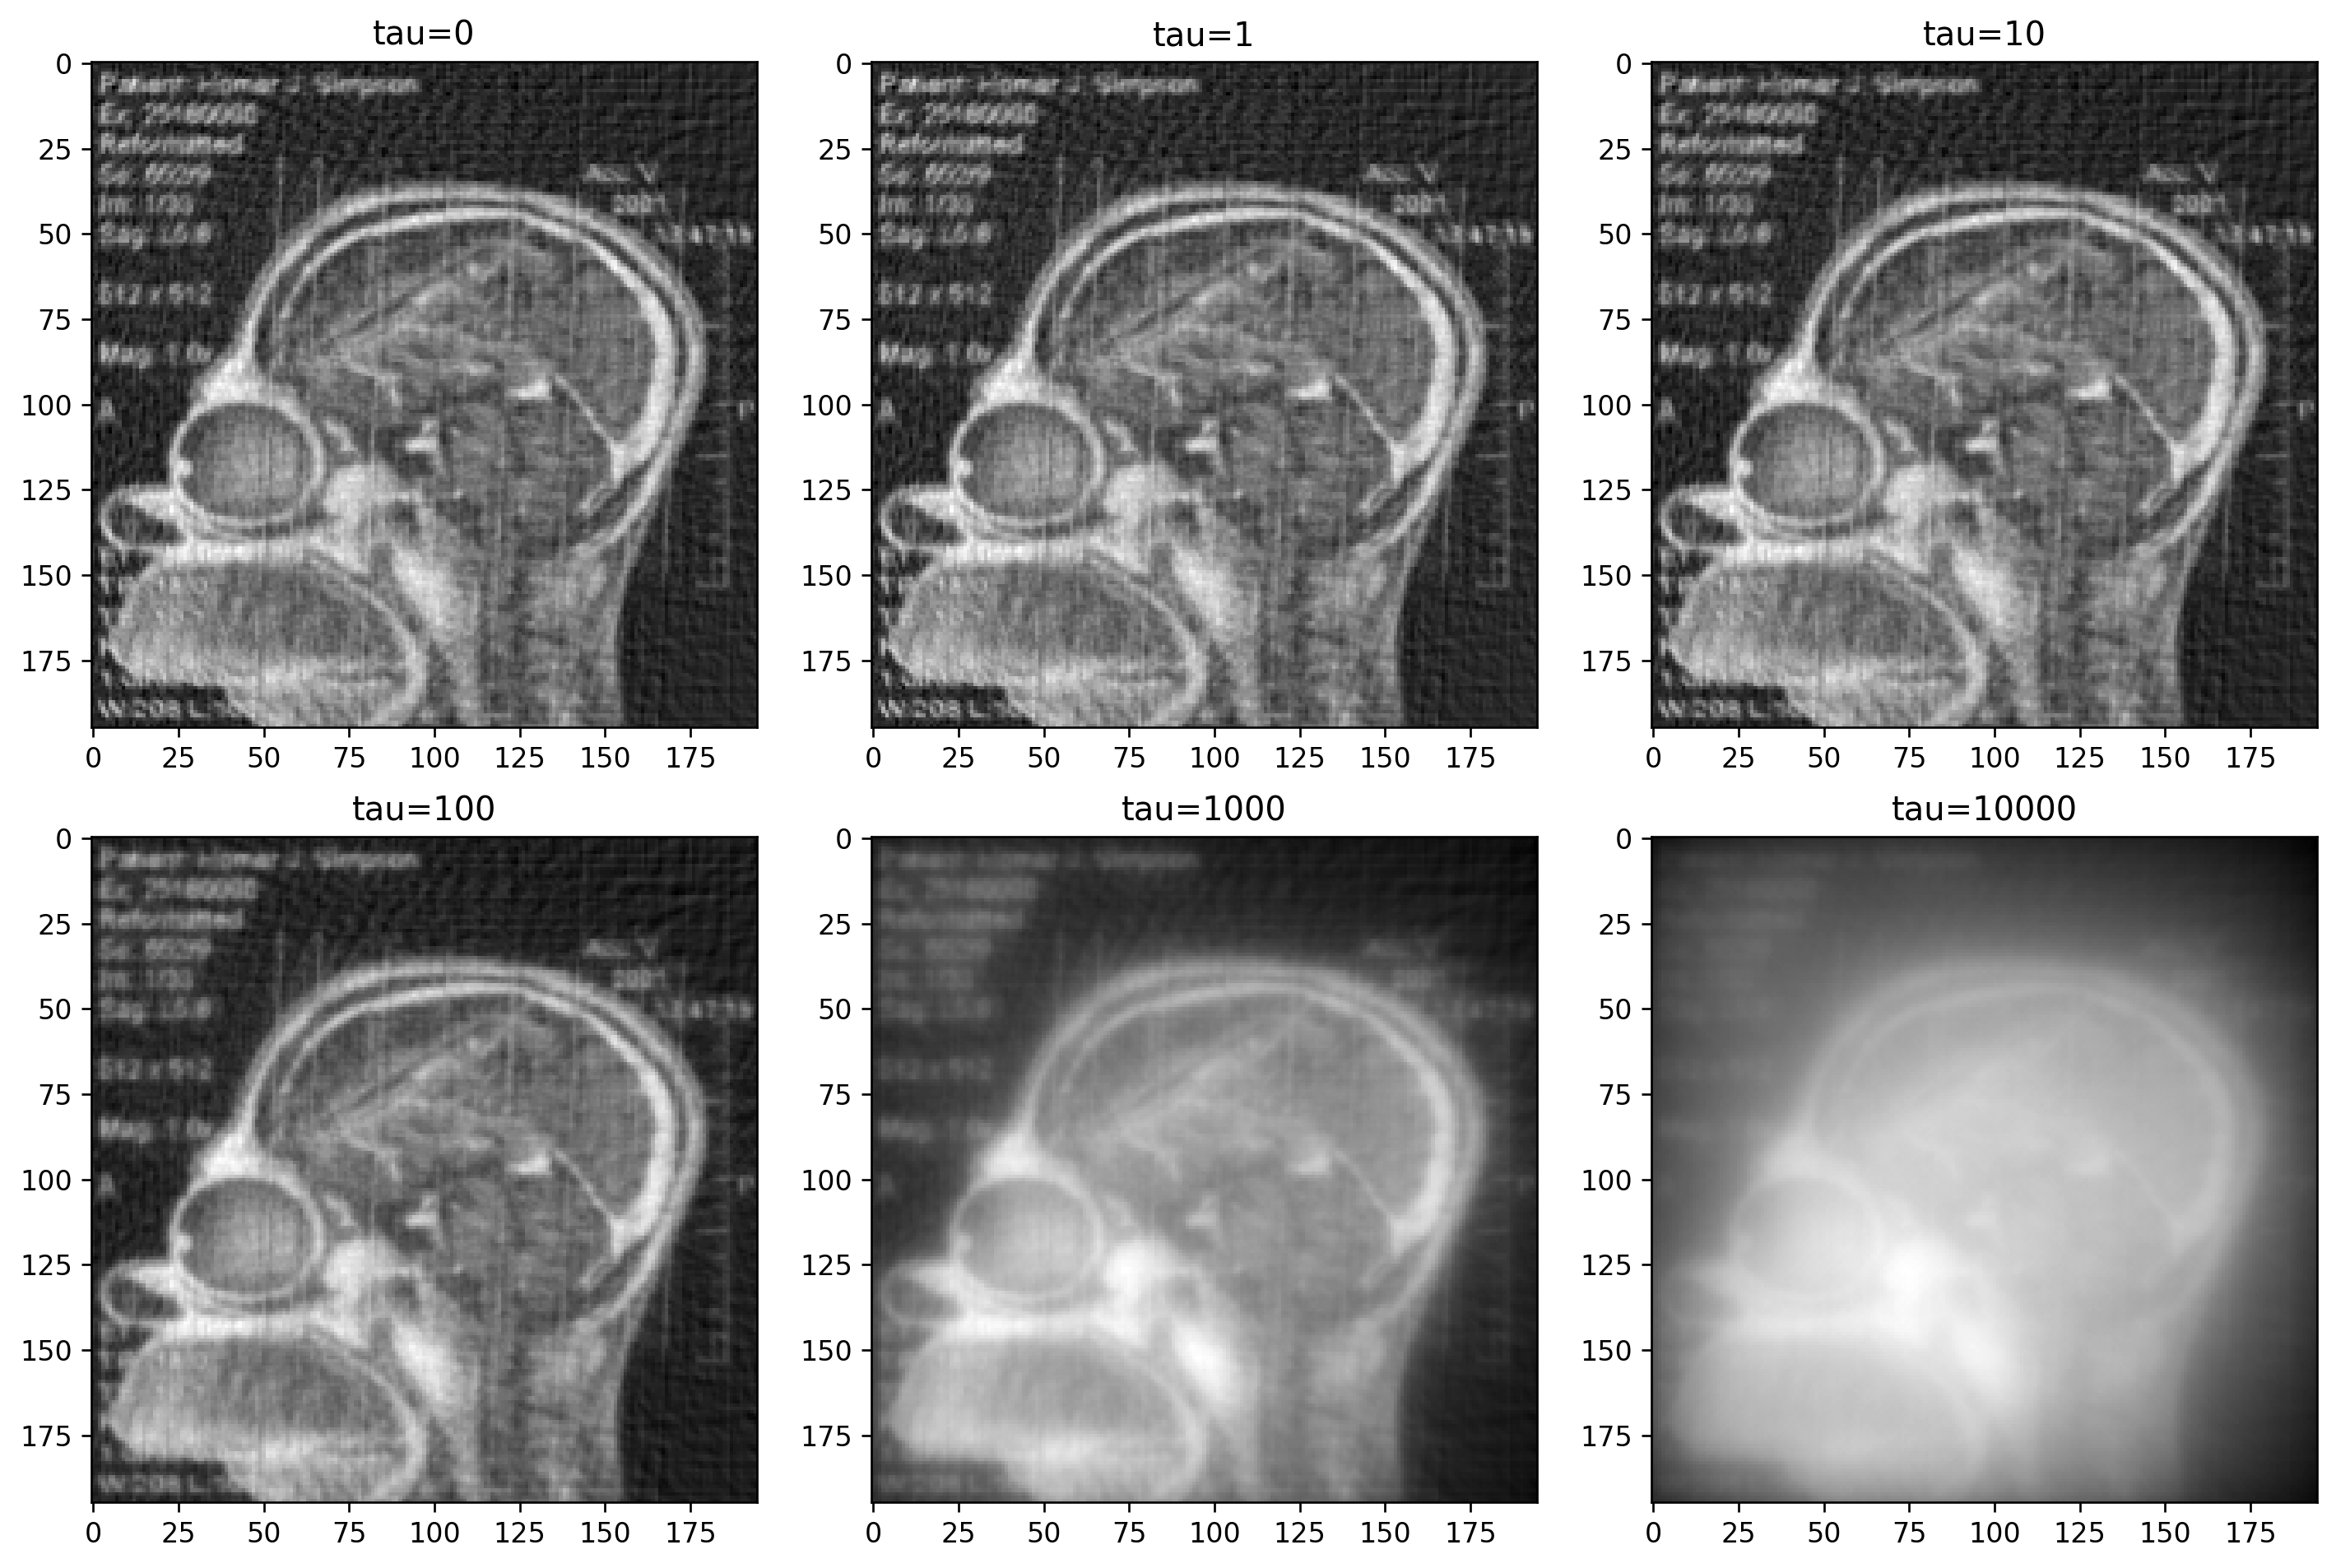

In [292]:
taus = [0, 1, 10, 100, 1000, 10000]

fig, axs = plt.subplots(2, 3, figsize=(12,8), dpi=240)
fig.tight_layout()
# make 1d for easier access
axs = np.ravel(axs)

atol = btol = 1e-04
plt.gray()
for i ,t in enumerate(taus):
    X = construct_X(M, alphas_64, NP, t)

    X_csc = X.tocsc()
    y = y_64
    if t > 0:
        y = np.append(y, np.zeros(M**2))
    beta, *_ = sppl.lsqr(X_csc, y, atol=atol, btol=btol)

    axs[i].imshow(beta.reshape((M, M)), interpolation="None")
    axs[i].set_title(f"tau={t}")

Although the text is barely readable, the foreign object in the head of the patient is still recognizable. For smaller objects, the tau would need to be smaller, but with an object as big as the crayon, a tau of 100 is still ok.


## Gaussian

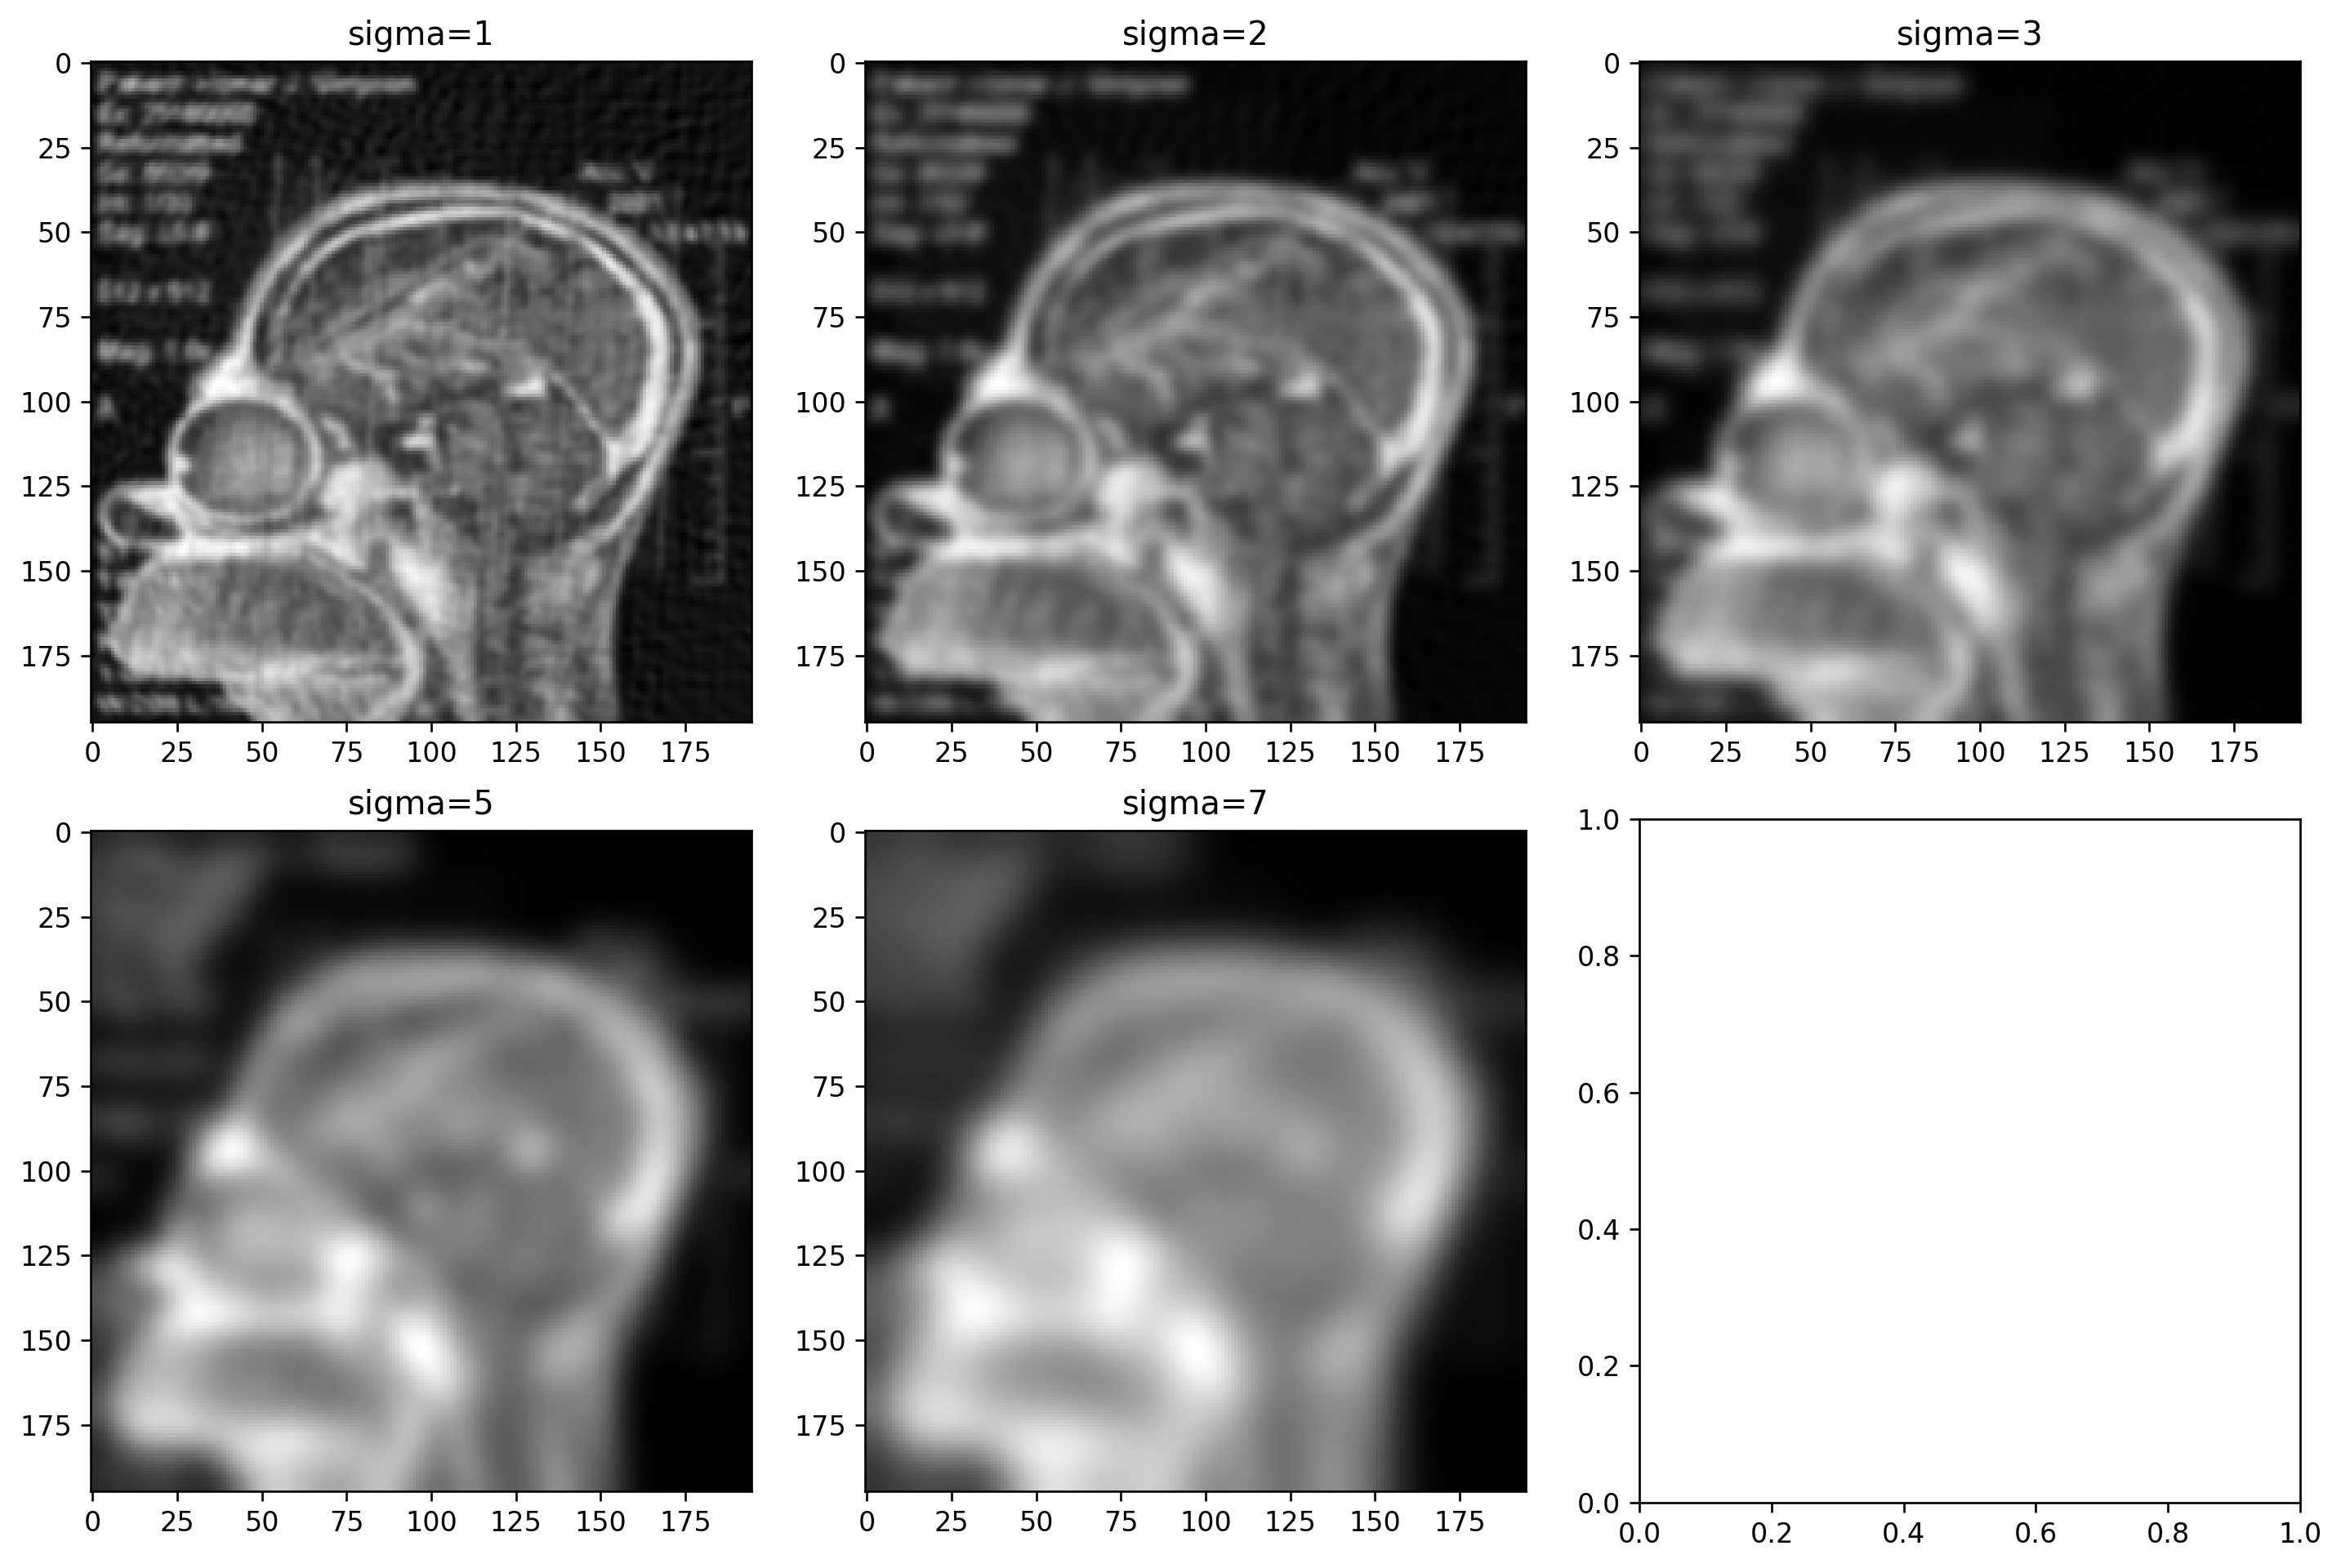

In [293]:
sigma = [1, 2, 3, 5, 7]

fig, axs = plt.subplots(2, 3, figsize=(12,8), dpi=240)
fig.tight_layout()
# make 1d for easier access
axs = np.ravel(axs)

atol = btol = 1e-04
plt.gray()
for i ,s in enumerate(sigma):
    X = construct_X(M, alphas_64, NP, 0)

    X_csc = X.tocsc()
    y = y_64

    beta, *_ = sppl.lsqr(X_csc, y, atol=atol, btol=btol)

    image = snf.gaussian_filter(beta.reshape(M, M), s)


    axs[i].imshow(image, interpolation="None")
    axs[i].set_title(f"sigma={s}")

## Differences


`Gaussian filter` smoothes the image but removes detail and `ridge regression` keeps most of the detail and removes mostly noise, but adds a slight shine.

# 3 Automatic feature selection for regression

## 3.1 Implement Orthogonal Matching Pursuit

In [294]:
import numba

In [295]:
@numba.jit(nopython=True)
def omp_regression(X: np.ndarray, y: np.ndarray, T: int):
    A = []
    B = list(range(X.shape[1]))
    r = y

    BETAS = np.zeros((X.shape[1], T))

    beta = 0
    for t in range(T):
        # 1
        j_t = np.argmax(
            np.abs(X[:, np.array(B)].T @ r)
        )

        # 2
        A.append(B.pop(j_t))

        # 3
        X_t = X[:, np.array(A)]

        # 4
        beta, residuals, _rank, _s = np.linalg.lstsq(X_t, y, rcond=-1)

        # 5
        r = (y - X_t.dot(beta))

        BETAS[np.array(A), t] = beta

    return BETAS


## 3.2 Classification with sparse LDA

In [296]:
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split

In [297]:
digits = load_digits()

data = digits["data"]  # type: ignore
images = digits["images"]  # type: ignore
target = digits["target"]  # type: ignore
target_names = digits["target_names"]  # type: ignore


new_indices = np.where((target==1) | (target==7))
data = data[new_indices]
target = target[new_indices]

new_target = np.ones_like(target, dtype=float)
new_target[target==7] = -1.

target = new_target


solution = omp_regression(data, target, data.shape[1])
best = solution[:, -1]


In [298]:
X_train: np.ndarray
X_test: np.ndarray
y_train: np.ndarray
y_test: np.ndarray

X_train, X_test, y_train, y_test = train_test_split(
    data, target, test_size=0.4, random_state=0  # type:ignore
)




In [299]:
def plot_mean_error_per_t(X_train, X_test, y_train, y_test):
    betas = omp_regression(X_train, y_train, X_train.shape[1])

    pred = np.sign(X_test@betas).T
    pred_train = np.sign(X_train@betas).T

    mean_err_test = np.mean(pred!=y_test, axis=1)
    mean_err_train = np.mean(pred_train!=y_train, axis=1)

    plt.figure(figsize=(12, 8))
    plt.plot(mean_err_test, label="Test Error")
    plt.plot(mean_err_train, label="Train Error")
    _ = plt.legend()


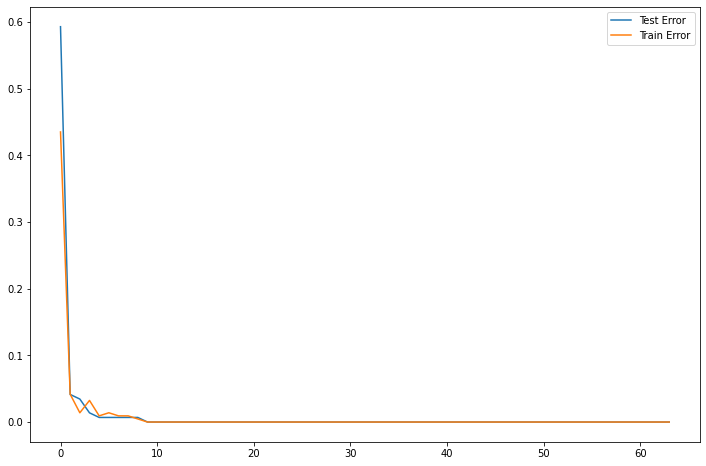

In [300]:
plot_mean_error_per_t(X_train, X_test, y_train, y_test)

For an acceptable error rate one should at least use around 5 or more pixels. After the 10th pixel there is no noticable improvement.

> #### Is it necessary/beneficial to standardize the data before training and testing?

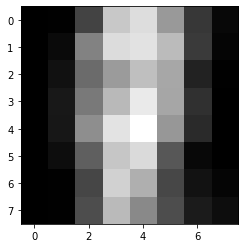

In [301]:
plt.imshow(np.mean(data, axis=0).reshape(8, 8))